imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from time import sleep
from basicsignalnoise_welch import signal_generator
from math import sqrt
from rbtree import RedBlackTree, Node
import os
import json

In [2]:
""" 
Only run this if your Pluto SDR is completely configured and you have installed the necessary libraries.
For help setting up your Pluto SDR or setting up libraries, go to the end of this notebook.
"""
from pluto_lib import PlutoSDR

In [3]:
#allosws plots to display in a separate window instead of in the notebook
# requires 'python -m pip install PyQt5'
%matplotlib qt

In [4]:
#allows plots to display in the notebook instead of another window
%matplotlib inline

Initialization

In [5]:
# configurations
rxlo = 914  # center frequency
rxfs = 40  # sampling rate in megasamples/second
RXFS = int(40 * 1e6)
rxbw = 40  # bw in MHz
buf_size = int((rxfs * 1e6)/10)  # 100 ms of a full second of samples
psd_len = 1024  # a power of 2 that holds spectrum obtain from welch's method
frames = 500

f = np.linspace(-(rxfs/2), (rxfs/2), psd_len)  # frequency in Hz
f = (f + rxlo) / 1e6

base_threshold = -55  # threshold signals need to meet to be considered relevant
significance_threshold = base_threshold

raw_data_memory = 0
packaged_data_memory = 0

config = {
    'rxlo [MHz]': int(rxlo),
    'rxfs [ms/s]': int(rxfs),
    'rxbw [MHz]': int(rxbw),
    'buffer size': int(buf_size),
    'psd length': psd_len,
    'number frames': frames,
    'base_threshold': base_threshold,
    'significance threshold': significance_threshold
}

samples = np.empty((frames, psd_len), dtype=np.float32)

save_directory = os.getcwd() + '/iq_data'
os.makedirs(save_directory, exist_ok=True)  # create a directory for the iq data

The two code sections below utilize different ways of gathering iq samples. The first way is using an actual Pluto SDR. If using the first method, make sure the Pluto SDR is configured correctly. Instructions on how to configure it can be found at the end of this notebook. If you do not have a Pluto SDR on hand, make sure to run the second code block which generates fake signals so that you can still see how I packaged iq samples and performed a z test to compare and characterize signals. 

This code uses threading to collect samples 

This code generates fake samples in the case a Pluto SDR is not available in order to still demonstrate how information is saved

In [6]:
_, iq_data = signal_generator([10000000], 0.1, 40000000)
_, empty_data = signal_generator([], 0.1, 40000000)
_, psd = signal.welch(iq_data, 40000000, 'hamming', psd_len, return_onesided=False, scaling='density', average='median')
psd_dB = np.fft.fftshift(10*np.log10((np.abs(psd)/psd.shape[0])**2)) + 150  # small miscalculation I made requiring an offset to correct the graph
for i in range(frames):
    samples[i] = psd_dB
significance_threshold = 0.75 * np.max(samples[0])
indices = np.where(samples > base_threshold)

x_indices = indices[0]
y_indices = indices[1]
x_indices.tofile(save_directory + '/x_indices.iq')
y_indices.tofile(save_directory + '/y_indices.iq')
samples[indices].tofile(save_directory + '/iq_data.iq')

raw_data_memory = samples.size * samples.itemsize

""" save the configurations as a text file """
with open(save_directory + '/config.txt', 'w') as config_file:
     config_file.write(json.dumps(config, indent=4))

Now that the samples and configurations have been saved in the **/iq_data** folder, the code below will demonstrate how those files are then used to reconstruct the data and display what's going on. Note how much data is saved by using this method. 

In [7]:
x_indices = np.fromfile(save_directory + '/x_indices.iq', np.int64)
y_indices = np.fromfile(save_directory + '/y_indices.iq', np.int64)
packaged_samples = np.fromfile(save_directory + '/iq_data.iq', np.float32)
packaged_config = {}
with open(save_directory + '/config.txt') as config_file: 
    packaged_config = json.load(config_file)

config_file_stats = os.stat(save_directory + '/config.txt')
packaged_data_memory = (x_indices.size*x_indices.itemsize) + (y_indices.size*y_indices.itemsize) + (packaged_samples.size*packaged_samples.itemsize) + config_file_stats.st_size

print(f"raw data [bytes]: {raw_data_memory}")
print(f"packaged data [bytes]: {packaged_data_memory}")
print(f"Configuration file [bytes]: {config_file_stats.st_size}")

raw data [bytes]: 2048000
packaged data [bytes]: 30219
Configuration file [bytes]: 219


Generate a single spectogram

Text(0, 0.5, 'Time [sec]')

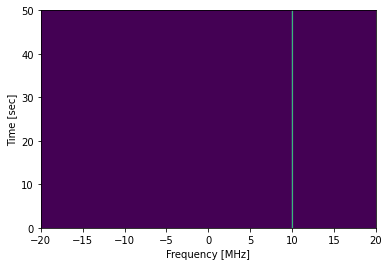

In [8]:
reconstructed_samples = np.zeros((frames, psd_len), dtype=np.float32)
reconstructed_samples += base_threshold
for i in range(len(x_indices)):
    reconstructed_samples[int(x_indices[i])][int(y_indices[i])] = packaged_samples[i]
plt.imshow(reconstructed_samples, aspect='auto', extent=[-rxfs/2, rxfs/2, 0, 0.1 * frames])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Time [sec]')

Text(0, 0.5, 'Amplitude [dB]')

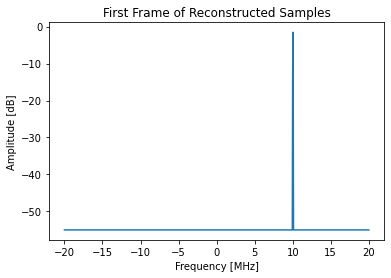

In [9]:
f = np.linspace(-rxfs/2, rxfs/2, psd_len)
plt.plot(f, reconstructed_samples[0])
plt.title("First Frame of Reconstructed Samples")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Amplitude [dB]")

Now, the z-test will be used to demonstrate how treating these signals as probability distributions make it easier to easier to distinguish between newly found signals and repeatedly found signals. 

In [10]:
freq_tree = RedBlackTree()
prev_x_idx = -1
prev_y_idx = -1
num_datapts = 1  # number of data points in the signal
start_y_idx = y_indices[0]  # starting frequency index of a found signal
for i in range(len(x_indices)):
    curr_x_idx = x_indices[i]
    curr_y_idx = y_indices[i]

    if prev_x_idx != -1:
        if (curr_x_idx == prev_x_idx) and (curr_y_idx == prev_y_idx + 1) and i != len(x_indices)-1:
            """ not the last entry and still looking at the same signal """
            num_datapts += 1

        else:
            """ processing the last signal that was seen """
            if i == len(x_indices)-1:
                """ on the last entry which means the last signal needs to be processed now """
                num_datapts += 1 
                prev_x_idx = curr_x_idx
                prev_y_idx = curr_y_idx

            bw = (rxfs/psd_len) * num_datapts  # bandwidth of the signal
            idx = np.argmax(reconstructed_samples[prev_x_idx][start_y_idx:prev_y_idx])
            mean = f[prev_y_idx + idx]  # mean of the signal
            amp = reconstructed_samples[prev_x_idx][start_y_idx + idx]  # peak amplitude of the signal

            sum = 0  # sum of all distances between each point and the mean
            for n in range(num_datapts):
                sum += abs(mean - reconstructed_samples[prev_x_idx][start_y_idx + n])

            std_dev = sqrt(sum/num_datapts)  # standard deviation of the signal

            closest: Node = freq_tree.approximateKey(mean)  # node closest in mean value to current signal
            if closest == freq_tree.TNULL:
                """ tree was empty, fill it with first entry """
                freq_tree.insert(mean, {
                    'std_dev': std_dev,
                    'num_datapts': num_datapts,
                    'bandwidth [MHz]': bw,
                    'amplitude [dB]': amp,
                    'occurrences': 1
                })
            else:
                """ perform z test on the node closest in mean value """
                c_mean = closest.item
                c_std_dev = closest.value['std_dev']
                c_num_datapts = closest.value['num_datapts']
                omega1 = std_dev/sqrt(num_datapts)
                omega2 = c_std_dev/sqrt(c_num_datapts)
                zval = abs(mean - c_mean)/sqrt(omega1 ** 2 + omega2 ** 2)

                if zval > 2.5:
                    """ z score indiciates signals are different """
                    freq_tree.insert(mean, {
                    'std_dev': std_dev,
                    'num_datapts': num_datapts,
                    'bandwidth [MHz]': bw,
                    'amplitude [dB]': amp,
                    'occurrences': 1
                })
                else:
                    """ the two signals are most likely the same, update values """
                    occurrences = closest.value['occurrences']
                    c_amp = closest.value['amplitude [dB]']

                    c_amp = (c_amp * occurrences) + amp
                    c_mean = (c_mean * occurrences) + mean

                    occurrences += 1

                    c_amp = c_amp / occurrences
                    c_mean = c_mean / occurrences

                    closest.value['amplitude [dB]'] = c_amp  # update average of amplitude
                    closest.item = c_mean  # update mean of the signal
                    closest.value['occurrences'] = occurrences  # update numer of occurrences

            """ reset basic variables for next signal """
            num_datapts = 1
            start_y_idx = curr_y_idx

    prev_x_idx = curr_x_idx
    prev_y_idx = curr_y_idx

tree_values = freq_tree.inorder()
keys = freq_tree.listKeys()

signals_properties = {}
for i in range(len(keys)):
    signals_properties[keys[i]] = tree_values[i]

""" save a file of all the signals found and their characteristics """
with open(save_directory + '/properties.txt', 'w') as properties_file:
     properties_file.write(json.dumps(signals_properties, indent=4))